In [69]:
# This program is being developed to implement current model research on a finite fracture 
# mechanics model for the prediction of the open-hole strength of composite laminates which can be 
# found at https://www.sciencedirect.com/science/article/abs/pii/S1359835X12000978 as part of a final
# year MEng project with supervisor Giuseppe Catalanotti. The program will output the crack length
# and remote stress at failure of a laminate under tensile load -- Sam Menary 06/02/21

# Imports
import mpmath
import itertools
import numpy as np
import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sympy import nsolve
from sympy.solvers import solve
from scipy import stats

def composite():
    # Inputs
    # Geometric properties (unit)
    R_obj = stats.norm(loc=5, scale=0.01)
    R_values = R_obj.rvs(size=2000) # (mm)
    W_obj = stats.norm(loc=60, scale=0.01)
    W_values = W_obj.rvs(size=2000)  # R/W must be < 1/2

    # Material properties (unit)
    XTL_obj = stats.norm(loc=845.1, scale=10)
    XTL_values = XTL_obj.rvs(size=2000) # (MPa) unnotched strength of the laminate
    KIC_obj = stats.norm(loc=1517, scale=10)
    KIC_values = KIC_obj.rvs(size=2000) # (MPamm^0.5) mode I fracture toughness of the laminate

    E1 = 171400  # (MPa)
    E2 = 9100  # (MPa)
    G12 = 5300  # (MPa)
    v12 = 0.3
    v21 = E2*(v12/E1)

    # Ply parameters
    number_of_plies = 24
    ply_thickness = [0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,
                     0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002] # (m) Enter value for each ply
    ply_angle = [90,0,45,-45,-45,45,0,90,90,0,45,-45,-45,45,0,90,90,0,45,-45,-45,45,0,90] # Enter value for each ply

    if len(ply_angle) != number_of_plies:
        print("Error. Please enter angle of every ply")
        exit()

    if len(ply_thickness) != number_of_plies:
        print("Error. Please enter thickness of every ply")
        exit()

    # Calculate Aij components of the laminate in-plane stiffness
    # Calculating list of trigonometric values: m = cosθ
    m_values = []
    i=0
    while i < number_of_plies:
        m = np.cos(np.radians(ply_angle[i]))
        m_values.append(m)
        i+=1

    # Calculating list of trigonometric values: n = sinθ
    n_values = []
    i=0
    while i < number_of_plies:
        n = np.sin(np.radians(ply_angle[i]))
        n_values.append(n)
        i+=1

    # Calculating Q values (constant for every ply)
    Q11 = E1/(1-(v12*v21))
    Q12 = (v21*E1)/(1-(v12*v21))
    Q21 = (v12*E2)/(1-(v12*v21))
    Q22 = E2/(1-(v12*v21))
    Q66 = G12

    #Calcuating Qbar values (different for every ply: depends on ply orientation)
    Qbar11_values = []
    i=0
    while i < number_of_plies:
        Qbar11 = ((m_values[i]**4)*(Q11))+((n_values[i]**4)*(Q22))+((2*(m_values[i]**2)*(n_values[i]**2))*(Q12))
        +((4*(m_values[i]**2)*(n_values[i]**2))*(Q66))
        Qbar11_values.append(Qbar11)
        i+=1

    Qbar12_values = []
    i=0
    while i < number_of_plies:
        Qbar12 = (((m_values[i]**2)*(n_values[i]**2))*(Q11))+(((m_values[i]**2)*(n_values[i]**2))*(Q22))
        +(((m_values[i]**4))*(Q12))+((-4*(m_values[i]**2)*(n_values[i]**2))*(Q66))
        Qbar12_values.append(Qbar12)
        i+=1

    Qbar21_values = []
    i=0
    while i < number_of_plies:
        Qbar21 = (((m_values[i]**2)*(n_values[i]**2))*(Q11))+(((m_values[i]**2)*(n_values[i]**2))*(Q22))+(((m_values[i]**4)
        +(n_values[i]**4))*(Q21))+((-4*(m_values[i]**2)*(n_values[i]**2))*(Q12))
        Qbar21_values.append(Qbar21)
        i+=1

    Qbar22_values = []
    i=0
    while i < number_of_plies:
        Qbar22 = ((n_values[i]**4)*(Q11))+((m_values[i]**4)*(Q22))+((2*(m_values[i]**2)*(n_values[i]**2))*(Q12))
        +((4*(m_values[i]**2)*(n_values[i]**2))*(Q66))
        Qbar22_values.append(Qbar22)
        i+=1    

    Qbar22_values = []
    i=0
    while i < number_of_plies:
        Qbar22 = ((n_values[i]**4)*(Q11))+((m_values[i]**4)*(Q22))+((2*(m_values[i]**2)*(n_values[i]**2))*(Q12))
        +((4*(m_values[i]**2)*(n_values[i]**2))*(Q66))
        Qbar22_values.append(Qbar22)
        i+=1  

    Qbar66_values = []
    i=0
    while i < number_of_plies:
        Qbar66 = (((m_values[i]**2)*(n_values[i]**2))*(Q11))+(((m_values[i]**2)*(n_values[i]**2))*(Q22))
        +((-2*(m_values[i]**2)*(n_values[i]**2))*(Q12))+((((m_values[i]**2)-(n_values[i]**2))**2)*(Q66))
        Qbar66_values.append(Qbar66)
        i+=1

    # Calculating A values (components of the laminate in-plane stiffness matrix)
    A11_values = []
    i=0
    while i < number_of_plies:
        A11 = Qbar11_values[i]*ply_thickness[i]
        A11_values.append(A11)
        i+=1
    A11 = sum(A11_values)

    A12_values = []
    i=0
    while i < number_of_plies:
        A12 = Qbar12_values[i]*ply_thickness[i]
        A12_values.append(A12)
        i+=1
    A12 = sum(A12_values)

    A21_values = []
    i=0
    while i < number_of_plies:
        A21 = Qbar21_values[i]*ply_thickness[i]
        A21_values.append(A21)
        i+=1
    A21 = sum(A21_values)

    A22_values = []
    i=0
    while i < number_of_plies:
        A22 = Qbar22_values[i]*ply_thickness[i]
        A22_values.append(A22)
        i+=1
    A22 = sum(A22_values)

    A66_values = []
    i=0
    while i < number_of_plies:
        A66 = Qbar11_values[i]*ply_thickness[i]
        A66_values.append(A66)
        i+=1
    A66 = sum(A66_values)

    # Creating empty lists for for loop outputs
    l_values = []
    σ_inf_values_list = []

    # For loop to create distribution outputs
    for R, W, XTL, KIC in zip(R_values, W_values, XTL_values, KIC_values):
        
        # Calculate M (geometric parameter)
        M = np.sqrt((np.sqrt(1-8*((3*(1-2*(R/W)))/(2+(1-2*(R/W))**3)-1))-1)/(2*((2*(R/W))**2)))

        # Calculating KT∞
        KT_inf = 1 + np.sqrt((2/A22)*((np.sqrt(A11*A22))-A12+((A11*A22-(A12**2))/(2*A66))))

        # Calculating RK
        RK = ((3*(1-2*(R/W)))/(2+(1-2*(R/W))**3)+(0.5*((2*R*M)/W)**6)*(KT_inf-3)*(1-((2*R*M)/W)**2))**-1

        # Calculating fn
        a = sp.Symbol('a')
        fn = 1 + 0.358*(R/a) + 1.425*(R/a)**2 - 1.578*(R/a)**3 + 2.156*(R/a)**4

        # Calculating Fh
        Fh = sp.sqrt(1-(R/a))*fn

        # Calculating Fw
        Fw = sp.sqrt(sp.sec(mpmath.radians((np.pi*R)/W)) * sp.sec(mpmath.radians((np.pi*a)/W)))

        # Solving for l
        # Integrating denominator
        x = sp.Symbol('x')
        l = sp.Symbol('l')
        integral_d = sp.integrate((2 + (R/x)**2 + 3*(R/x)**4 - (KT_inf-3)*((5*(R/x)**6)-7*(R/x)**8)),(x,R,R+l))

        # Calculating denominator
        denom = RK**2*(integral_d)**2

        #Integrating numerator using the Simpson's Rule
        ul = R+l # upper limit
        ll = R # lower limit
        n = 10 # number of strips (must be even)
        h = (ul-ll)/n # height of each strip
        f = ((Fh*Fw)**2)*a

        a_values = []
        i=0
        while i <= n:
            dh = ll + h*i
            a_values.append(dh)
            i+=1

        a_values_odd = a_values[1::2] # creates list of only values in odd index positions
        a_values_even = a_values[2:n:2] # creates list of only values in even index positions excluding first and last

        i = 0
        integral_n_odd_values = []
        while i < len(a_values_odd):
            integral_n_odd = 4*(f.subs(a,a_values_odd[i]))
            integral_n_odd_values.append(integral_n_odd)
            i+=1

        i = 0
        integral_n_even_values = []
        while i < len(a_values_even):
            integral_n_even = 2*(f.subs(a,a_values_even[i]))
            integral_n_even_values.append(integral_n_even)
            i+=1

        integral_n = (h/3)*(f.subs(a,a_values[0])+(f.subs(a,a_values[n]))+sum(integral_n_odd_values)+sum(integral_n_even_values))

        # Calculating numerator
        numer = 4*l*np.pi*integral_n

        # Calculating l
        l_equation = (numer/denom)-(KIC/XTL)**2
        l = nsolve(l_equation, l, (0,W-R))

        # Calculating stress distribution across x-axis
        σ_inf = sp.Symbol('σ_inf')
        σyy = ((RK*σ_inf)/2)*((2+(R/x)**2)+3*((R/x)**4)-((KT_inf-3)*((5*(R/x)**6)-(7*(R/x)**8))))

        # Integrating and calculating LHS of equation 1 to solve for σ_inf
        ul = R+l # upper limit
        ll = R # lower limit
        n = 10 # number of strips (must be even)
        h = (ul-ll)/n # height of each strip
        f = ((RK*σ_inf)/2)*((2+(R/x)**2)+3*((R/x)**4)-((KT_inf-3)*((5*(R/x)**6)-(7*(R/x)**8))))

        x_values = []
        i=0
        while i <= n:
            dh = ll + h*i
            x_values.append(dh)
            i+=1

        x_values_odd = x_values[1::2] # creates list of only values in odd index positions
        x_values_even = x_values[2:n:2] # creates list of only values in even index positions excluding first and last

        i = 0
        integral_n_odd_values = []
        while i < len(x_values_odd):
            integral_n_odd = 4*(f.subs(x,x_values_odd[i]))
            integral_n_odd_values.append(integral_n_odd)
            i+=1

        i = 0
        integral_n_even_values = []
        while i < len(x_values_even):
            integral_n_even = 2*(f.subs(x,x_values_even[i]))
            integral_n_even_values.append(integral_n_even)
            i+=1

        integral_1 = (h/3)*(f.subs(x,x_values[0])+(f.subs(x,x_values[n]))+sum(integral_n_odd_values)+sum(integral_n_even_values))
        eq_1 = ((1/l)*integral_1)-XTL
        σ_inf = solve(eq_1,σ_inf)

        # Appending l and σ_inf from each iteration to the created lists
        l_values.append(l)
        σ_inf_values_list.append(σ_inf)
        σ_inf_values = list(itertools.chain(*σ_inf_values_list)) # Creating single list from 'list of lists'
    
    # Finding the mean value of l and σ_inf from output distributions
    l_values_mean = sum(l_values)/len(l_values)
    σ_inf_values_mean = sum(σ_inf_values)/len(σ_inf_values)
    
    # Showing input and output distributions and output mean results
    print("Mean crack length at failure (l) = " + str(l_values_mean) + " mm")
    print("Mean remote stress at failure (σ_inf) = " + str(σ_inf_values_mean) + " MPa")

    # Plotting input and output distributions
    plt.figure(figsize=(10,16))

    plt.subplot(4, 2, 1)
    R_plot = sns.distplot(R_values)
    R_plot.set(xlabel="R (mm)", ylabel = "Density")
    R_plot.set_title('INPUTS', x=1.15, y=1.1, fontsize=20)

    plt.subplot(4,2,2)
    W_plot = sns.distplot(W_values)
    W_plot.set(xlabel="W (mm)", ylabel = "Density")

    plt.subplot(4, 2, 3)
    XTL_plot = sns.distplot(XTL_values)
    XTL_plot.set(xlabel="XTL (MPa)", ylabel = "Density")

    plt.subplot(4, 2, 4)
    KIC_plot = sns.distplot(KIC_values)
    KIC_plot.set(xlabel="KIC (MPamm^0.5)", ylabel = "Density")

    plt.subplot(4, 2, 5)
    l_plot = sns.distplot(l_values)
    l_plot.set(xlabel="l (mm)", ylabel = "Density")
    l_plot.set_title('OUTPUTS', x=1.15, y=1.1, fontsize=20)

    plt.subplot(4,2,6)
    σ_inf_plot = sns.distplot(σ_inf_values)
    σ_inf_plot.set(xlabel="σ_inf (MPa)", ylabel = "Density")

    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

Mean crack length at failure (l) = 1.79693269837596 mm
Mean remote stress at failure (σ_inf) = 383.736078666487 MPa


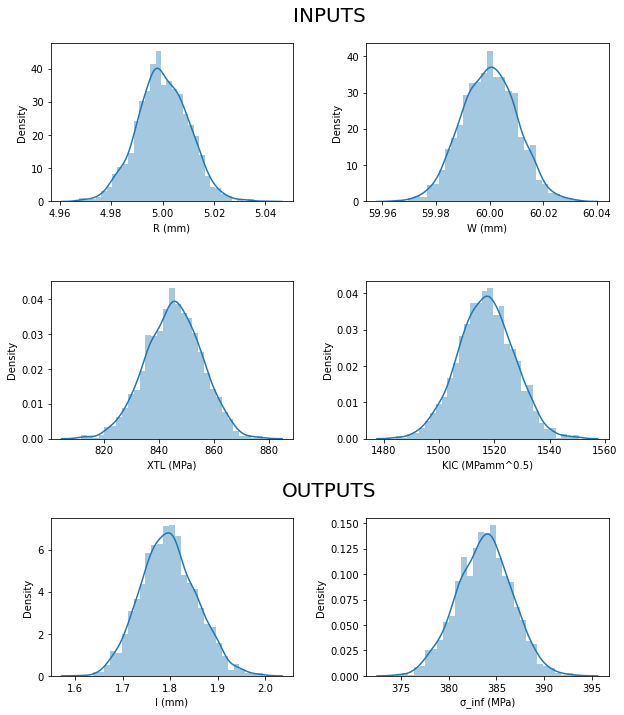

In [70]:
composite()